# ***Tarea 6. Primera red neuronal***
### Luis Eduardo Jiménez del Muro - 13/03/2025
---

# *Paqueterías y funciones*

In [12]:
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt

from sklearn.metrics import r2_score
from sklearn.linear_model import LinearRegression, Ridge
from sklearn.preprocessing import StandardScaler, PolynomialFeatures
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.pipeline import Pipeline
from sklearn.neural_network import MLPRegressor

import warnings
warnings.filterwarnings('ignore')

In [26]:
# Gráfica de calibracion
def calibracion(predicciones, y, bins):
    df_calibracion = pd.DataFrame({
        'predicciones':predicciones,
        'y':y
    })
    df_calibracion['bins'] = pd.qcut(df_calibracion['predicciones'], q=bins, labels=False) + 1
    grouped = df_calibracion.groupby('bins').mean()
    r2 = r2_score(y_pred=predicciones, y_true=y)
    
    # Gráfica
    plt.figure(figsize=(7,5))
    plt.plot(grouped['predicciones'], grouped['predicciones'], label='Real', color='red', lw=2)
    plt.plot(grouped['predicciones'], grouped['y'], label='Modelo', marker='o', color='cadetblue', ms=4, lw=2)
    plt.title(f'Calibración del modelo \n\n$R2={r2:.4f}$', fontweight='bold')
    plt.grid(alpha=0.3)
    plt.legend()

    
# Regresión Polinómica grado n
def polynomial(X, y, type, n, q):
    scaler = StandardScaler().fit(X)
    X_scaled = scaler.transform(X)

    poly_features = PolynomialFeatures(degree=n)
    X_poly = poly_features.fit_transform(X_scaled)
    X_train, X_test, y_train, y_test = train_test_split(X_poly, y, test_size=0.3, random_state=42)

    model = type.fit(X_train, y_train)
    predicciones_poly_2 = model.predict(X_test)
    calibracion(predicciones_poly_2, y_test, q)

def nn_regresion(X, y, q):
    X_train, X_test, y_train, y_test = train_test_split(
        X, y, test_size=0.3, random_state=42
    )

    pipeline = Pipeline([
        ('scaler', StandardScaler()),
        ('poly', PolynomialFeatures()),
        ('nn', MLPRegressor())
    ])
    params_grid = {
        'poly__degree': [1, 2],
        'nn__hidden_layer_sizes': [(5,5,5), (10,), (100,), (50,50,50), (10,10), (100,100), (100,100,100), (1,2,3,4,5)],
        'nn__activation': ['tanh', 'relu', 'logistic'],
        'nn__alpha': [0.1, 0.01]
    }

    grid_nn = GridSearchCV(estimator=pipeline, param_grid=params_grid, cv=5, n_jobs=-1, scoring='r2').fit(X_train, y_train)
    predicciones_nn = grid_nn.best_estimator_.predict(X_test)

    print(grid_nn.best_params_)
    calibracion(predicciones_nn, y_test, q)

# *Preparar los datos*

In [5]:
df = pd.read_csv('data/Boston.csv')
df = df.drop(columns=['Unnamed: 0'])
df = pd.get_dummies(df, columns=['rad'])
df.head()

,crim,zn,indus,chas,nox,rm,age,dis,tax,ptratio,...,medv,rad_1,rad_2,rad_3,rad_4,rad_5,rad_6,rad_7,rad_8,rad_24
0,0.00632,18.0,2.31,0,0.538,6.575,65.2,4.0900,296,15.3,...,24.0,True,False,False,False,False,False,False,False,False
1,0.02731,0.0,7.07,0,0.469,6.421,78.9,4.9671,242,17.8,...,21.6,False,True,False,False,False,False,False,False,False
2,0.02729,0.0,7.07,0,0.469,7.185,61.1,4.9671,242,17.8,...,34.7,False,True,False,False,False,False,False,False,False
3,0.03237,0.0,2.18,0,0.458,6.998,45.8,6.0622,222,18.7,...,33.4,False,False,True,False,False,False,False,False,False
4,0.06905,0.0,2.18,0,0.458,7.147,54.2,6.0622,222,18.7,...,36.2,False,False,True,False,False,False,False,False,False


# *Mejor modelo realizado en el examen*

## Variables creadas en feature engeneering

In [7]:
# Variables modificadas
modified_features_df = pd.DataFrame()
modified_features_df['rm_2'] = df['rm']**2
modified_features_df['tax_2'] = df['tax']**2
modified_features_df['nox_2'] = df['nox']**2
modified_features_df['ptratio_2'] = df['ptratio']**2
modified_features_df['indus_2'] = df['indus']**2
modified_features_df['crim_2'] = df['crim']**2
modified_features_df['age_2'] = df['age']**2
modified_features_df['lstat_2'] = df['lstat']**2
modified_features_df['ln_dist'] = np.log(1+df['dis']) # +1 para evitar ln(0)

# Nuevas variables
new_features_df = pd.DataFrame()
new_features_df['crim_indus'] = df['crim'] / (1+df['indus']) # +1 para evitar divisiones entre cero
new_features_df['crim_lstat'] = df['crim'] / (1+df['lstat'])
new_features_df['rm_lstat'] = df['rm'] / (1+df['lstat'])
new_features_df['nox_indus'] = df['nox'] / (1+df['indus'])
new_features_df['nox_dis'] = df['nox'] / (1+df['dis'])
new_features_df['age_lstat'] = df['age'] / (1+df['lstat'])
new_features_df['tax_rm'] = df['tax'] / (1+df['rm'])
new_features_df['tax_lstat'] = df['tax'] / (1+df['lstat'])
new_features_df['ptratio_rm'] = df['ptratio'] / (1+df['rm'])
new_features_df['ptratio_nox'] = df['ptratio'] / (1+df['nox'])
new_features_df['ptratio_dis'] = df['ptratio'] / (1+df['dis'])
new_features_df['nox_age'] = df['nox'] / (1+df['age'])
new_features_df['dis_indus'] = df['dis'] / (1+df['indus'])
new_features_df['tax_indus'] = df['tax'] / (1+df['indus'])

# Nuevos dataframes para futuras pruebas
df_mod_plus_originals = pd.concat([df, modified_features_df], axis=1)
df_new_feat_plus_originals = pd.concat([df, new_features_df], axis=1)
df_all_new_plus_originals = pd.concat([df, modified_features_df, new_features_df], axis=1)
df_all_new_not_originals = pd.concat([df[['medv']], modified_features_df, new_features_df], axis=1)

## Modelo

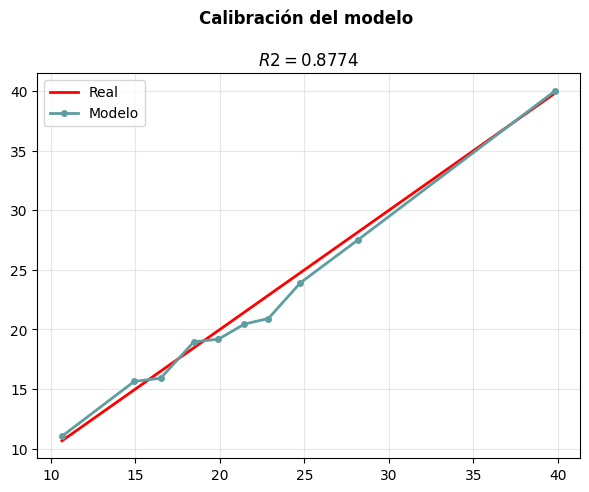

In [9]:
target = 'medv'
X = df_all_new_not_originals.copy().drop(columns={target})
y = df[target]

polynomial(X, y, Ridge(), 2, 10)

# *Modelos de redes neuronales*

## Modelo utilizando las variables originales + dummies 

{'nn__activation': 'relu', 'nn__alpha': 0.1, 'nn__hidden_layer_sizes': (100, 100, 100), 'poly__degree': 2}


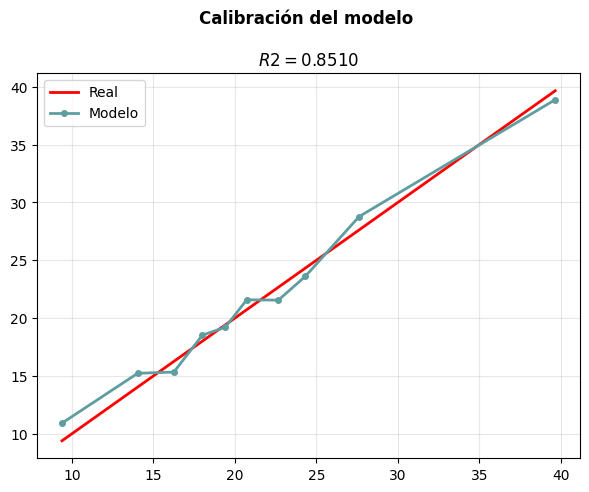

In [27]:
X = df.copy().drop(target, axis=1)
y = df[target]

nn_regresion(X, y, 10)

## Modelo utilizando las variables del mejor resultado en el examen

{'nn__activation': 'relu', 'nn__alpha': 0.1, 'nn__hidden_layer_sizes': (100, 100, 100), 'poly__degree': 1}


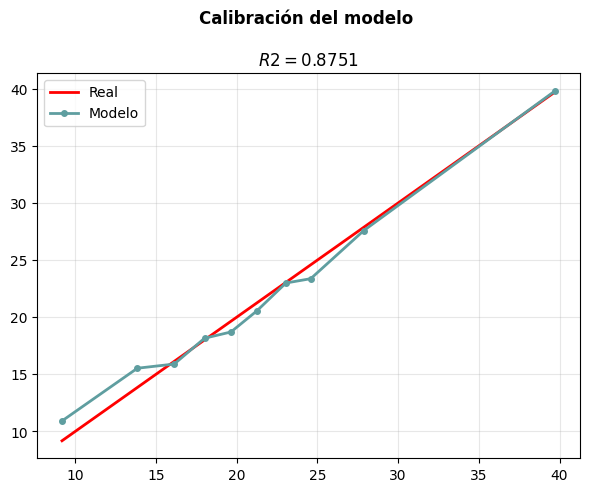

In [28]:
X = df_all_new_not_originals.copy().drop(columns={target})
y = df[target]

nn_regresion(X, y, 10)

# *Conclusiones*

La implementación de redes neuronales tuvo un buen resultado, ya que, el modelo que realicé en el examen despues de un largo análisis de los datos y feature engeneering obtuvo un $\text{R}^2 = 0.8774$, mientras que la simple red neuronal con los datos originales y sin haber creado ninguna nueva variable obtuvo un $\text{R}^2 = 0.8510.$

Esto significa que aunque en el examen se obtuvo un ajuste un poco mejor, la red neuronal tuvo casi el mismo desempeño y ni siquiera tuvo que realizarse un análisis a los datos, por lo que, estos modelos pueden ser convenientes para entregar un modelo robusto y de buenos resultados en muy poco tiempo.

Además la red neuronal utilizando las variables que obtuvieron el mejor $\text{R}^2$ en el examen tuvo prácticamente el mismo resultado a la regresión realizada en el examen, por lo que, se puede observar que una vez realizando un análisis a los datos y feature engeneering, no será tan relevante utilizar una red neuronal comparado a una simple regresión.

La desventaja de estos modelos de redes neuronales es que son mas tardados de entrenar, por lo que, aunque nos ahorramos el tiempo de analisar los datos, por otra parte, tenemos que esperar mas tiempo entrenando el modelo (dependiendo de la que tan compleja sea la red que estamos proponiendo).